In [1]:
# Imports 
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio
%matplotlib inline

In [2]:
# Get folder locations
current_directory = os.getcwd()
photo_1 = os.path.join(current_directory, 'Obama.jpeg')
photo_2 = os.path.join(current_directory,'Bush.jpeg')

# Convert to the np format
images = [cv2.imread(photo_1),cv2.imread(photo_2)]

In [3]:
def read_file_np_array(src_file_name, triangle_list_file_name, dest_file_name):
    # Reads the files for the landmarks and triangles (pre generated from DLIB)
    return np.genfromtxt(src_file_name, delimiter=",", dtype=np.int64), np.genfromtxt(triangle_list_file_name, delimiter=",", dtype=np.int64), np.genfromtxt(dest_file_name, delimiter=",", dtype=np.int64)

src_pts, triangles, dest_pts = read_file_np_array("src_points.txt","triangles.txt","dest_points.txt")

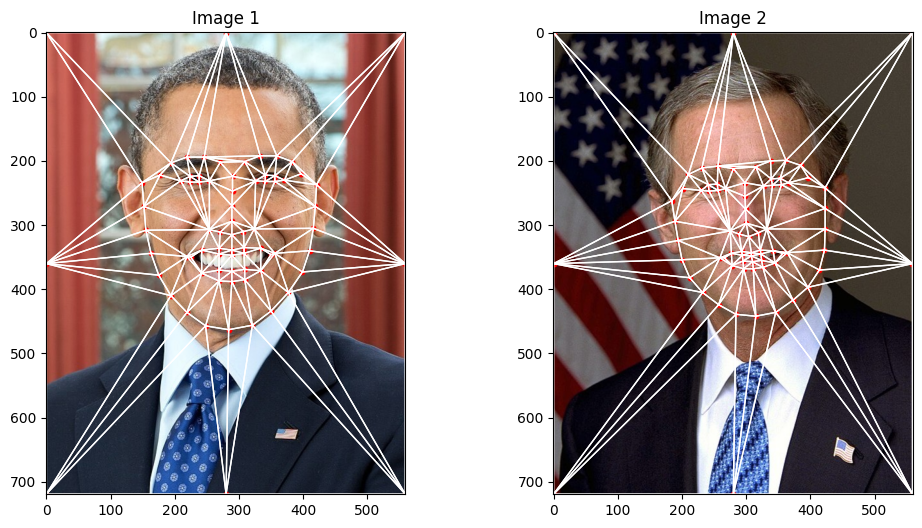

In [4]:
# Plot images with landmarks

# Create a new figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image
axes[0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
axes[0].scatter(src_pts[:, 0], src_pts[:, 1], color='red', s=10)  # Plot landmarks
axes[0].set_title('Image 1')

# Plot the triangles on the first image
for triangle_indices in triangles:
    triangle = src_pts[triangle_indices]
    triangle = np.vstack([triangle, triangle[0]])  # Connect the last point to the first
    axes[0].plot(triangle[:, 0], triangle[:, 1], color='white', linewidth=1)

# Plot the second image
axes[1].imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
axes[1].scatter(dest_pts[:, 0], dest_pts[:, 1], color='red', s=10)  # Plot landmarks
axes[1].set_title('Image 2')

# Plot the triangles on the second image
for triangle_indices in triangles:
    triangle = dest_pts[triangle_indices]
    triangle = np.vstack([triangle, triangle[0]])  # Connect the last point to the first
    axes[1].plot(triangle[:, 0], triangle[:, 1], color='white', linewidth=1)

# Show the plot
plt.show()

In [5]:
def get_affine_transform(src_tri, dst_tri):
    # Calculate the transformation matrix using the inverse:
    #   M = inv(src) * dst
    src_inv = np.linalg.pinv(src_tri)

    # Calculate the transformation matrix M
    affine_matrix = np.dot(dst_tri, src_inv)

    return affine_matrix

def reshape_triangle_for_transformation(triangle):
    # Converts triangle into the format : [[x1,y1],[x2,y2], [x3,y3]] -> [[x1,x2,x3], [y1,y2,y3], [1,1,1]]
    triangle = np.transpose(triangle)
    row_of_ones = np.ones((1, triangle.shape[1]))  
    triangle = np.vstack([triangle, row_of_ones])
    return triangle

def bilinear_interpolation(src_image, src_x, src_y):
    # Extract integer coordinates
    x_floor, y_floor = np.floor(src_x).astype(int), np.floor(src_y).astype(int)
    
    # Ensure indices are within the image boundaries
    x_floor = np.clip(x_floor, 0, src_image.shape[1] - 2)
    y_floor = np.clip(y_floor, 0, src_image.shape[0] - 2)

    # Calculate delta x and delta y after clipping
    x_frac, y_frac = src_x - x_floor, src_y - y_floor

    # Get pixel values at four corners with reversed y_floor and x_floor
    top_left = src_image[y_floor, x_floor]
    top_right = src_image[y_floor, x_floor + 1]
    bottom_left = src_image[y_floor + 1, x_floor]
    bottom_right = src_image[y_floor + 1, x_floor + 1]

    # Perform bilinear interpolation
    interpolated_values = x_frac * y_frac * bottom_right + \
                          x_frac * (1 - y_frac) * top_right + \
                          (1 - x_frac) * y_frac * bottom_left + \
                          (1 - x_frac) * (1 - y_frac) * top_left

    return interpolated_values


def warp_affine(src, warp_mat, size):
    width, height = size

    # Generate pixel coordinates for the output image
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Flatten the coordinates and add a row of ones for homogeneous coordinates
    coordinates = np.column_stack((x.flatten(), y.flatten(), np.ones_like(x.flatten())))
  
    # Calculate the inverse transformation matrix (used pinv incase the inverse doesn't exist i.e. singular matrix)
    inv_warp_mat = np.linalg.pinv(warp_mat)

    # Apply the inverse transformation to get coordinates in the original image
    transformed_coordinates = np.dot(inv_warp_mat, coordinates.T)

    # Extract x and y coordinates
    src_x = transformed_coordinates[0]
    src_y = transformed_coordinates[1]

    # Perform bilinear interpolation for each channel by providing all the x and y values for the warped image
    dst = np.zeros((height, width, src.shape[2]), dtype=src.dtype)
    for c in range(src.shape[2]):
        dst[:, :, c] = bilinear_interpolation(src[:, :, c], src_x, src_y).reshape(height,width)

    return dst

In [6]:
def apply_affine_transform(src, srcTri, dstTri, size) :
    # Given a pair of triangles, find the affine transform.
    srcTri = reshape_triangle_for_transformation(srcTri)
    dstTri = reshape_triangle_for_transformation(dstTri)
    warpMat = get_affine_transform(srcTri,dstTri)

    # Apply the Affine Transform just found to the src image
    dst = warp_affine(src,warpMat,size)

    return dst

def triangle_morphing(img1, img2, result_img, src_triangle, dest_triangle, int_triangle, w):
    # Find bounding rectangle for each triangle
    src_img_bounding_rect = cv2.boundingRect(np.float32([src_triangle]))
    dest_img_bounding_rect = cv2.boundingRect(np.float32([dest_triangle]))
    inter_img_bouding_rect = cv2.boundingRect(np.float32([int_triangle]))
    
    # Zero centers the triangle vertices (easier to work with)
    int_rect = []
    src_rect = []
    dest_rect = []

    for i in range(0, 3):
        int_rect.append(((int_triangle[i][0] - inter_img_bouding_rect[0]), (int_triangle[i][1] - inter_img_bouding_rect[1])))
        src_rect.append(((src_triangle[i][0] - src_img_bounding_rect[0]), (src_triangle[i][1] - src_img_bounding_rect[1])))
        dest_rect.append(((dest_triangle[i][0] - dest_img_bounding_rect[0]), (dest_triangle[i][1] - dest_img_bounding_rect[1])))

    # Get mask by filling the triangle
    mask = np.zeros((inter_img_bouding_rect[3], inter_img_bouding_rect[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(int_rect), (1.0, 1.0, 1.0), 16, 0)
 
    # Apply warpImage to small rectangular patches
    img1_rectangular = img1[src_img_bounding_rect[1]:src_img_bounding_rect[1] + src_img_bounding_rect[3], src_img_bounding_rect[0]:src_img_bounding_rect[0] + src_img_bounding_rect[2]]
    img2_rectangular = img2[dest_img_bounding_rect[1]:dest_img_bounding_rect[1] + dest_img_bounding_rect[3], dest_img_bounding_rect[0]:dest_img_bounding_rect[0] + dest_img_bounding_rect[2]]

    # Apply the transformations to get the warped rectangular patches
    size = (inter_img_bouding_rect[2], inter_img_bouding_rect[3]) # size -> (width, height)
    warp_image1 = apply_affine_transform(img1_rectangular, src_rect, int_rect, size)
    warp_image2 = apply_affine_transform(img2_rectangular, dest_rect, int_rect, size)

    # Alpha blend rectangular patches
    blended_warped_img = (1.0 - w) * warp_image1 + w * warp_image2
    
    # Copy triangular region of the rectangular patch to the output image
    result_img[inter_img_bouding_rect[1]:inter_img_bouding_rect[1]+inter_img_bouding_rect[3], inter_img_bouding_rect[0]:inter_img_bouding_rect[0]+inter_img_bouding_rect[2]] = result_img[inter_img_bouding_rect[1]:inter_img_bouding_rect[1]+inter_img_bouding_rect[3], inter_img_bouding_rect[0]:inter_img_bouding_rect[0]+inter_img_bouding_rect[2]] * (1 - mask) + blended_warped_img * mask

In [7]:
def images_to_video(images, output_file):
    # Patch images together to create the video
    with imageio.get_writer(output_file, mode='I', fps=30) as writer:
            for k in range(len(images)):
                writer.append_data(np.asarray(images[k]))

def plot_int_images(imgs_list):
    # Plot the intermediate images
    _, axes = plt.subplots(5, 10, figsize=(15, 8))
    axes = axes.flatten()
    for i in range(len(imgs_list)):
        axes[i].imshow(np.array(imgs_list[i]))
        axes[i].axis('off')
        axes[i].set_title(f"Image: {i+1}")

    plt.show()


In [8]:
def face_morph_generation(duration,frame_rate,img1,img2,src_img_points,dest_img_points,lst_of_triangles,output):

    num_images = int(duration*frame_rate)
    frames_for_video = [] # Stores Morphed Frames
  
    for j in range(0, num_images):

        # Convert Mat to float data type
        img1 = np.float32(img1)
        img2 = np.float32(img2)

        # Read array of corresponding points
        points = []
        w = j/(num_images-1)
        
        # Compute weighted average point coordinates
        for i in range(0, len(src_img_points)):
            x = (1 - w) * src_img_points[i][0] + w * dest_img_points[i][0]
            y = (1 - w) * src_img_points[i][1] + w * dest_img_points[i][1]
            points.append((x,y))

        # Allocate space for final output
        morphed_frame = np.zeros(img1.shape, dtype = img1.dtype)

        # Morphing the triangles
        for i in range(len(lst_of_triangles)):   
            x = int(lst_of_triangles[i][0])
            y = int(lst_of_triangles[i][1])
            z = int(lst_of_triangles[i][2])
            
            # Get the triangle vertices for the src, dest and morph image
            src_tri_vertices = [src_img_points[x], src_img_points[y], src_img_points[z]]
            dest_tri_vertices = [dest_img_points[x], dest_img_points[y], dest_img_points[z]]
            morph_tri_vertices = [points[x], points[y], points[z]]

            # Morph one triangle at a time.
            triangle_morphing(img1, img2, morphed_frame, src_tri_vertices, dest_tri_vertices, morph_tri_vertices, w)

        # Convert image from BGR format to RGB and store it the list to create the video
        result = Image.fromarray(cv2.cvtColor(np.uint8(morphed_frame), cv2.COLOR_BGR2RGB))
        frames_for_video.append(result)

    # Convert frames to video
    images_to_video(frames_for_video, output)

    # Plot the images
    plot_int_images(frames_for_video)

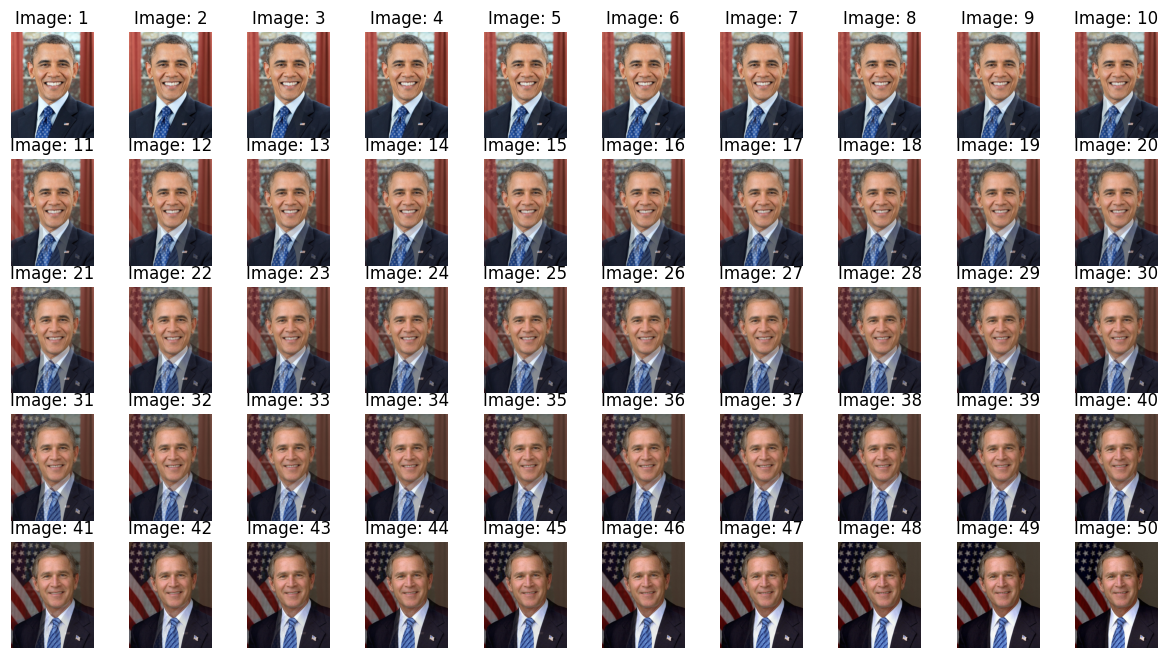

In [9]:
# Output folder path  
output_path = os.path.join(current_directory, 'output.mp4')

face_morph_generation(5, 10, images[0], images[1], src_pts, dest_pts, triangles,output_path)